In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
from pathlib import Path
import numpy as np

import sys
sys.path.append('../')
from pathlib import Path

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from VAE.model import CVAE
from dataset import SimLaw

from copy import deepcopy
from utils import infer_u, gen_x, pcf_mix, cf_eval

In [3]:
class Args:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    u_dim = 3
    r_dim = 8 
    d_dim = 2
    act_fn = 'Tanh'
    use_label = True
    dataset = 'law'
args = Args()

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FONTSIZE = 20
METRIC_DICT = {'cf_effect':r'$TE$',
                'cf_effect0':r'$TE_0$',
                'cf_effect1':r'$TE_1$'}

In [5]:
def cvae_prepare_data(datasets, model):

    data_dict = {}
    model.eval()

    for split in ['train', 'test']:
        cur_data_dict = {}
        dataset = datasets[split]

        r,d,a,y,u = dataset.r, dataset.d, dataset.a, dataset.y, dataset.u
        x = torch.cat([r,d], dim=1)
        x_cf, a_cf, y_cf = dataset.x_cf, dataset.a_cf, dataset.y_cf 
        

        x = x.to(DEVICE)
        r = r.to(DEVICE)
        d = d.to(DEVICE)
        u = u.to(DEVICE)
        y = y.to(DEVICE)
        a = a.to(DEVICE)
        x_cf = x_cf.to(DEVICE)
        y_cf = y_cf.to(DEVICE)
        a_cf = a_cf.to(DEVICE)

        cur_data_dict['x'] = x
        cur_data_dict['y'] = y 
        cur_data_dict['a'] = a
        cur_data_dict['u'] = u
        cur_data_dict['x_cf'] = x_cf    
        cur_data_dict['y_cf'] = y_cf
        cur_data_dict['a_cf'] = a_cf

        u_hat = infer_u(model, r, d, a)
        u_cf_hat = infer_u(model, x_cf[:,:8], x_cf[:,8:], a_cf)
        x_cf_uhat = gen_x(model, u_hat, a_cf)
        x_cf_cf_uhat = gen_x(model, u_cf_hat, a)

        cur_data_dict['u_hat'] = u_hat
        cur_data_dict['u_cf_hat'] = u_cf_hat
        cur_data_dict['x_cf_uhat'] = x_cf_uhat
        cur_data_dict['x_cf_cf_uhat'] = x_cf_cf_uhat

        for key, data in cur_data_dict.items():
            cur_data_dict[key] = data.detach().cpu().numpy()
            
        data_dict[split] = cur_data_dict
        

    return data_dict

In [6]:
def ermsoft_classifier(data_dict, clf, alpha=1):
    train_dat = data_dict["train"]
    test_dat = data_dict["test"]
    
    inputs = np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1)
    y = train_dat["y"].ravel()

    clf.fit(inputs, y)
    train_acc = mean_squared_error(y, clf.predict(inputs),squared=False)



    y_factual = clf.predict(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    
    acc = mean_squared_error(test_dat["y"].ravel(), y_factual.ravel(),squared=False)

    y_counter = clf.predict(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    a = test_dat["a"]
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf

def cfesoft_classifier(data_dict, clf, alpha=1):

    train_dat = data_dict["train"]
    test_dat = data_dict["test"]

    clf_erm = deepcopy(clf)
    clf = deepcopy(clf)
    clf_erm.fit(np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1), 
                train_dat["y"].ravel())
    
    inputs =  train_dat["u_hat"]
    y = train_dat["y"].ravel()
    clf.fit(inputs, y)
    train_acc = mean_squared_error(y, clf.predict(inputs),squared=False)


    y_factual_cfe = clf.predict(test_dat["u_hat"])
    y_factual_erm = clf_erm.predict(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    y_factual = alpha * y_factual_cfe + (1-alpha) * y_factual_erm
    acc = mean_squared_error(test_dat["y"].ravel(), y_factual.ravel(),squared=False)


    y_counter_cfe = clf.predict(test_dat["u_cf_hat"])
    y_counter_erm = clf_erm.predict(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    y_counter = alpha * y_counter_cfe + (1-alpha) * y_counter_erm
    a = test_dat["a"]
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf

def cfrsoft_classifier(data_dict, clf, alpha=1):

    train_dat = data_dict["train"]
    test_dat = data_dict["test"]

    clf_erm = deepcopy(clf)
    clf = deepcopy(clf)
    clf_erm.fit(np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1), 
                train_dat["y"].ravel())
    
    inputs = np.concatenate([train_dat["u_hat"], 
                        (train_dat["x"] + train_dat["x_cf_uhat"]) / 2], axis=1)
    y = train_dat["y"].ravel()
    clf.fit(inputs, y)
    train_acc = mean_squared_error(y, clf.predict(inputs),squared=False)

    y_factual_cfr = clf.predict(np.concatenate([
        test_dat["u_hat"],
        (test_dat["x"] + test_dat["x_cf_uhat"]) / 2
    ], axis=1))
    y_factual_erm = clf_erm.predict(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    y_factual = alpha * y_factual_cfr + (1-alpha) * y_factual_erm
    acc = mean_squared_error(test_dat["y"].ravel(), y_factual.ravel(),squared=False)

    y_counter_cfr = clf.predict(np.concatenate([
        test_dat["u_cf_hat"],
        (test_dat["x_cf"] + test_dat["x_cf_cf_uhat"]) / 2
    ], axis=1))
    a = test_dat["a"]
    y_counter_erm = clf_erm.predict(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    y_counter = alpha * y_counter_cfr + (1-alpha) * y_counter_erm
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf


def pcfsoft_classifier(data_dict, clf, alpha=1):
    train_dat = data_dict["train"]
    test_dat = data_dict["test"]

    clf_erm = deepcopy(clf)
    clf = deepcopy(clf)
    clf_erm.fit(np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1), 
                train_dat["y"].ravel())
    
    inputs = np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1)
    y = train_dat["y"].ravel()
    clf.fit(inputs, y)
    train_acc = mean_squared_error(y, clf.predict(inputs),squared=False)

    # ======= factual pred ======= #
    y_factual_score = clf.predict(np.concatenate([test_dat["x"],
                                                test_dat['a']],axis=1))
    y_factual_cf_score = clf.predict(np.concatenate([test_dat["x_cf_uhat"],
                                                     test_dat['a_cf']],axis=1))
    
    y_factual_pcf = pcf_mix(y_factual_score, y_factual_cf_score, test_dat['a'].ravel())

    y_factual_erm = clf_erm.predict(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    y_factual = alpha * y_factual_pcf + (1-alpha) * y_factual_erm
    acc = mean_squared_error(test_dat["y"].ravel(), y_factual.ravel(), squared=False)

    # ======= counter pred ======= #
    y_counter_score = clf.predict(np.concatenate([test_dat["x_cf"],
                                                        test_dat['a_cf']],axis=1))
    y_counter_cf_score = clf.predict(np.concatenate([test_dat["x_cf_cf_uhat"],
                                                        test_dat['a']],axis=1))
    y_counter_pcf = pcf_mix(y_counter_score, y_counter_cf_score, test_dat['a_cf'].ravel(),is_cf=True)
    y_counter_erm = clf_erm.predict(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    y_counter = alpha * y_counter_pcf + (1-alpha) * y_counter_erm

    a = test_dat["a"]
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf

def pcfaugsoft_classifier(data_dict, clf, alpha=1):
    train_dat = data_dict["train"]
    test_dat = data_dict["test"]
    
    clf_erm = deepcopy(clf)
    clf = deepcopy(clf)
    clf_erm.fit(np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1), 
                train_dat["y"].ravel())

    inputs = np.concatenate([
    np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1),
    np.concatenate([train_dat["x_cf_uhat"],
                             train_dat['a_cf']],axis=1)],axis=0)
    y = np.concatenate([train_dat["y"],train_dat["y"]],axis=0).ravel()
    clf.fit(inputs, y)

    train_acc = mean_squared_error(y, clf.predict(inputs),squared=False)

    # ======= factual pred ======= #
    y_factual_score = clf.predict(np.concatenate([test_dat["x"],
                                                test_dat['a']],axis=1))
    y_factual_cf_score = clf.predict(np.concatenate([test_dat["x_cf_uhat"],
                                                     test_dat['a_cf']],axis=1))
    
    y_factual_pcf = pcf_mix(y_factual_score, y_factual_cf_score, test_dat['a'].ravel())
    
    y_factual_erm = clf_erm.predict(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    y_factual = alpha * y_factual_pcf + (1-alpha) * y_factual_erm
    acc = mean_squared_error(test_dat["y"].ravel(), y_factual.ravel(), squared=False)

    # ======= counter pred ======= #
    y_counter_score = clf.predict(np.concatenate([test_dat["x_cf"],
                                                        test_dat['a_cf']],axis=1))
    y_counter_cf_score = clf.predict(np.concatenate([test_dat["x_cf_cf_uhat"],
                                                        test_dat['a']],axis=1))
    y_counter_pcf = pcf_mix(y_counter_score, y_counter_cf_score, test_dat['a_cf'].ravel(),is_cf=True)
    y_counter_erm = clf_erm.predict(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    y_counter = alpha * y_counter_pcf + (1-alpha) * y_counter_erm

    a = test_dat["a"]
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf


In [7]:
def eco_mix(y_score, y_score_1_a, ycf_score, ycf_score_a, a, is_cf=False):
    # attribute corresponding to y
    a_0_indices = a == 0
    a_1_indices = a == 1
    a_0_ratio = np.sum(a_0_indices) / len(a)
    a_1_ratio = 1 - a_0_ratio
    if is_cf:
        # we need to use the ratio in the real data
        a_0_ratio, a_1_ratio = a_1_ratio, a_0_ratio

    y_output = np.zeros_like(y_score.ravel())
    
    y_output[a_0_indices] = a_0_ratio * (a_0_ratio * y_score[a_0_indices] + a_1_ratio * y_score_1_a[a_0_indices]) + \
                             a_1_ratio * (a_1_ratio * ycf_score[a_0_indices] + a_0_ratio * ycf_score_a[a_0_indices])
    
    y_output[a_1_indices] = a_1_ratio * (a_1_ratio * y_score[a_1_indices] + a_0_ratio * y_score_1_a[a_1_indices]) + \
                             a_0_ratio * (a_0_ratio * ycf_score[a_1_indices] + a_1_ratio * ycf_score_a[a_1_indices])

    return y_output

def ecosoft_classifier(data_dict, clf, alpha=1):
    train_dat = data_dict["train"]
    test_dat = data_dict["test"]
    
    clf_erm = deepcopy(clf)
    clf = deepcopy(clf)
    clf_erm.fit(np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1), 
                train_dat["y"].ravel())

    inputs = np.concatenate([train_dat["x"],
                             train_dat['a']],axis=1)
    y = train_dat["y"].ravel()
    clf.fit(inputs, y)

    train_acc = mean_squared_error(y, clf.predict(inputs),squared=False)

    # ======= factual pred ======= #
    y_factual_score = clf.predict(np.concatenate([test_dat["x"], test_dat['a']], axis=1))
    y_factual_score_1_a = clf.predict(np.concatenate([test_dat["x"], 1 - test_dat['a']], axis=1))
    y_factual_cf_score = clf.predict(np.concatenate([test_dat["x_cf_uhat"], test_dat['a_cf']], axis=1))
    y_factual_cf_score_a = clf.predict(np.concatenate([test_dat["x_cf_uhat"], 1 - test_dat['a_cf']], axis=1))
    
    y_factual_eco = eco_mix(y_factual_score, y_factual_score_1_a, y_factual_cf_score, y_factual_cf_score_a, test_dat['a'].ravel())
    
    y_factual_erm = clf_erm.predict(np.concatenate([test_dat["x"],
                                            test_dat['a']],axis=1))
    y_factual = alpha * y_factual_eco + (1-alpha) * y_factual_erm
    acc = mean_squared_error(test_dat["y"].ravel(), y_factual.ravel(), squared=False)

    # ======= counter pred ======= #
    y_counter_score = clf.predict(np.concatenate([test_dat["x_cf"], test_dat['a_cf']], axis=1))
    y_counter_score_1_a = clf.predict(np.concatenate([test_dat["x_cf"], 1 - test_dat['a_cf']], axis=1))
    y_counter_cf_score = clf.predict(np.concatenate([test_dat["x_cf_cf_uhat"], test_dat['a']], axis=1))
    y_counter_cf_score_a = clf.predict(np.concatenate([test_dat["x_cf_cf_uhat"], 1 - test_dat['a']], axis=1))
    
    y_counter_eco = eco_mix(y_counter_score, y_counter_score_1_a, y_counter_cf_score, y_counter_cf_score_a, test_dat['a_cf'].ravel(), is_cf=True)
    y_counter_erm = clf_erm.predict(np.concatenate([test_dat["x_cf"],
                                            test_dat['a_cf']],axis=1))
    y_counter = alpha * y_counter_eco + (1-alpha) * y_counter_erm

    a = test_dat["a"]
    cf_effect, cf_effect0, cf_effect1 = cf_eval(y_factual, y_counter, a)

    return train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf

In [8]:
def eval_ild(global_dir,
             all_res,
             regressor_type='mlp'
             ):

    seed_list = [1,2,3,4,5]
    for seed in seed_list:

        args.seed = seed
        train_set = SimLaw(split='train', root=global_dir)
        test_set = SimLaw(split='test', root=global_dir)
        datasets = {'train':train_set, 'test':test_set}

        model_dir = global_dir / f'law/est/cvae/a_r_1.0_a_d_1.0_a_y_1.0_a_f_0.0_u_3_run_{seed}_use_label_True/model.pth' 
        model = CVAE(r_dim=args.r_dim,
                        d_dim=args.d_dim, 
                        sens_dim=1, 
                        label_dim=1, 
                        args=args).to(args.device)
        model.load_state_dict(torch.load(model_dir))

        data_dict = cvae_prepare_data(datasets, model)
        for lamb in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            for method, classifier in zip(['cfr', 'cfe','pcf', 'pcfaug','erm','eco'],
                                        [cfrsoft_classifier, cfesoft_classifier, pcfsoft_classifier, pcfaugsoft_classifier, ermsoft_classifier, ecosoft_classifier]):
                if regressor_type == 'mlp':
                    predictor = MLPRegressor(hidden_layer_sizes=(20,20),max_iter=2000,activation='tanh')
                else:
                    raise ValueError("Invalid regressor type")
                train_acc, acc, cf_effect, cf_effect0, cf_effect1, clf = classifier(data_dict, predictor, alpha=lamb)
                res = dict()
                res['seed'] = seed
                res['train_error'] = train_acc
                res['test_error'] = acc
                res['method'] = method
                res['clf'] = clf
                res['cf_effect'] = cf_effect
                res['cf_effect0'] = cf_effect0
                res['cf_effect1'] = cf_effect1
                res['lamb'] = lamb
                all_res = all_res.append(res, ignore_index=True)

    return all_res

In [14]:

def vis_ild_alg(all_res, save_dir=None,mute=[]):
# Split the 'method' column to separate 'method' and 'group'
    
    all_res = all_res.copy()

    #display(all_res)
    if len(mute)>0:
        for mm in mute:
            all_res = all_res[all_res['method']!=mm]
    #display(all_res)
    replace_dict = {}
    replace_dict['cda'] = 'CDA'
    replace_dict['cfe'] = 'CFU'
    replace_dict['cfr'] = 'CFR'
    replace_dict['erm'] = 'ERM'
    replace_dict['npcf'] = 'nPCF'
    replace_dict['pcf'] = 'PCF'
    replace_dict['pcfaug'] = 'PCF-CRM'
    replace_dict['eco'] = 'ECOCF'
    for alpha in [0,0.2,0.4,0.6,0.8,1]:
        replace_dict[alpha] = f'PCFaug-{alpha}'

    all_res['method'] = all_res['method'].replace(replace_dict)
    all_res = all_res.groupby(by=['method','lamb']).mean().reset_index()
    lamb_order = sorted(all_res['lamb'].unique())
    print(lamb_order)

        
    all_res['style'] = all_res['method']

    # Define the plot size
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

    for col in ['cf_effect', 'cf_effect0', 'cf_effect1']:
        fig, ax = plt.subplots(figsize=(10,6))
        # Create the scatter plot with unique styles
        sns.scatterplot(data=all_res, x=col, y='test_error', style='method', hue='lamb', s=200, ax=ax)

        for method in all_res['method'].unique():
            method_data = all_res[all_res['method'] == method]
            #sns.lineplot(data=method_data, x=col, y='test_error', ax=ax, label=method, legend=False)
            ax.plot(method_data[col], method_data['test_error'], label='_nolegend_', linestyle=':',alpha=0.5)
        
        #ax.set_title(col)
        ax.set_xlabel(METRIC_DICT[col],fontsize=FONTSIZE)
        ax.set_ylabel('RMSE',fontsize=FONTSIZE)
        ax.legend(fontsize=FONTSIZE,markerscale=2, bbox_to_anchor=(1, 1), loc='upper left')
        plt.xticks(fontsize=FONTSIZE, rotation=30)
        plt.yticks(fontsize=FONTSIZE)

        #plt.tight_layout()
        # plt.show()
        if save_dir:
            plt.savefig(f'{save_dir}_{col}.png', bbox_inches='tight',dpi=200)
            plt.show()
        else:
            plt.show()
        

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


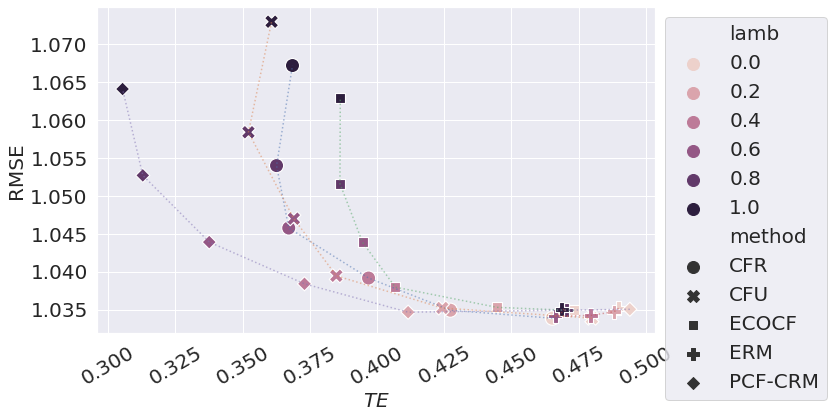

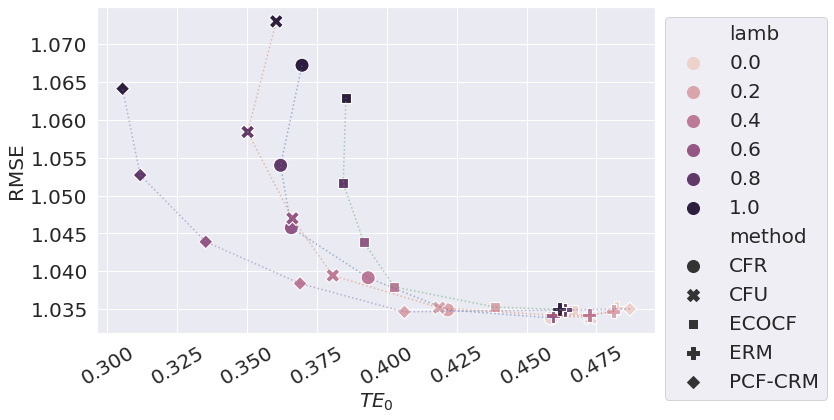

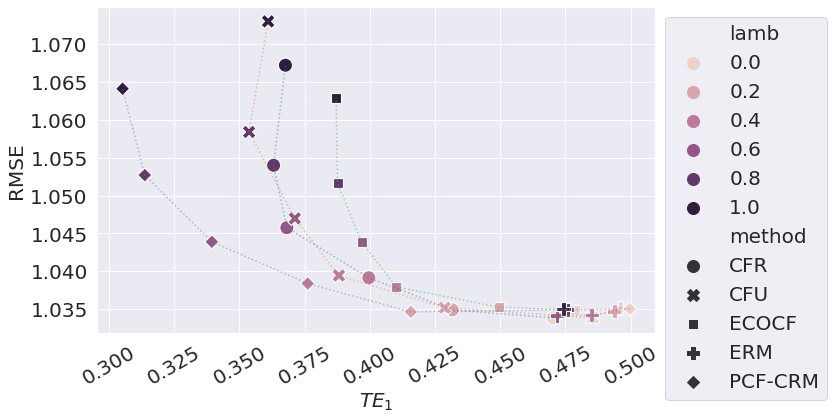

In [10]:

all_res = pd.DataFrame()

# ILD
clf_name = 'mlp'
global_dir = Path('../VAE/saved/final')
all_res = eval_ild(global_dir,
                 all_res,
                 regressor_type=clf_name)
vis_ild_alg(all_res, save_dir=f'../figures/law/estaug_{clf_name}',mute=['pcf'])


[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


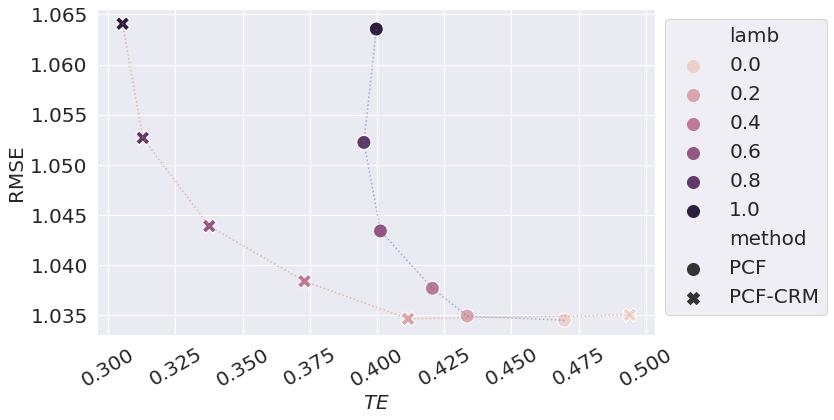

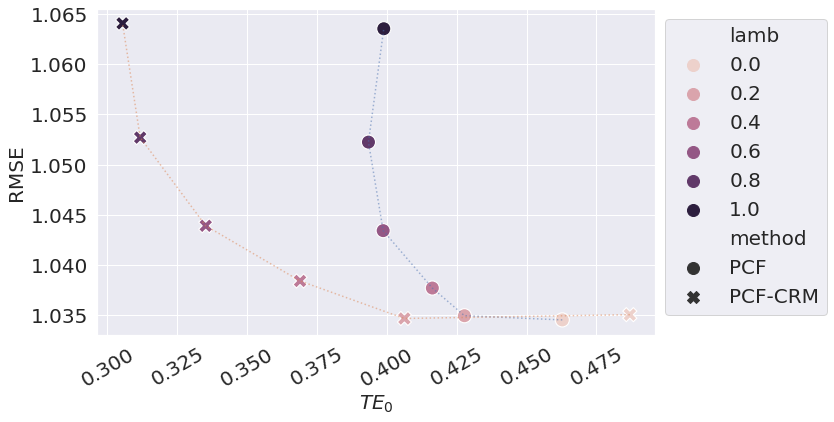

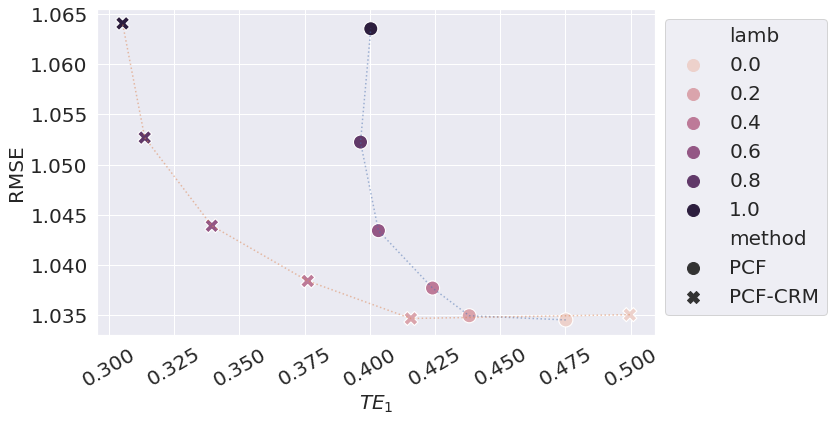

In [15]:
vis_ild_alg(all_res, save_dir=f'../figures/law/estaug_pcfcrm_{clf_name}',
            mute=['cfr','cfe','erm','eco'])
